
# Phi-3 Zero-Shot Inference

In [1]:
#val_or_test_split = 'val'
val_or_test_split = 'test'

In [2]:
!pip install -q transformers datasets sentencepiece accelerate evaluate tiktoken einops flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 41.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 85.6 MB/s eta 0:00:00
ERROR: 

In [3]:
from datasets import load_dataset

hf_site_id = '2024-mcm-everitt-ryan'
dataset_id = f'{hf_site_id}/job-bias-synthetic-human-benchmark-v2'
dataset = load_dataset(dataset_id)
column_names = dataset['train'].column_names

text_col = 'text'
label_cols = [col for col in column_names if col.startswith('label_')]

labels = [label.replace("label_", "") for label in label_cols]

id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

# Remove all columns apart from the two needed for multi-class classification
keep_columns = ['context_id', 'synthetic', text_col] + label_cols
for split in ["train", "val", "test"]:
    dataset[split] = dataset[split].remove_columns(
        [col for col in dataset[split].column_names if col not in keep_columns])


Generating train split:   0%|          | 0/4609 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/593 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/584 [00:00<?, ? examples/s]

# Prompt Formatting & Data preprocessing

Inspiration from https://medium.com/@olaf.lenzmann/mastering-llms-for-complex-classification-tasks-64f0bda2edf3

In [4]:
context = "You are an analyst of job postings.\n"
instruction = "Your job is to analyse a job posting and determine if it contains implicit bias towards or against certain groups. The bias categories are age, disability, feminine, masculine, racial, sexuality, general, neutral. Return the appropriate label only when absolutely sure that the particular bias category is present in the text.\n"
closing_instruction = "Does the job posting contain any implicit bias? Please respond in the format of 'Labels: <labels>' where the possible labels are zero or more from the choices of age, disability, feminine, masculine, racial, sexuality, general. If no biased language is present, please return zero labels. No further explanation is required."

def construct_prompt_zero_shot (query_job_description):
    evidence = f"Job Posting: \n {query_job_description} \n ===END=== \n"
    content = context + instruction + evidence + closing_instruction
    messages = [{"role": "user", "content": content}]
    return messages

In [5]:
def get_formatted_prompt(job_description):
    msgs = construct_prompt_zero_shot(job_description)
    return msgs

In [6]:
import numpy as np

# Create 'prompt' and 'labels'
def preprocess_data(sample):
    # take a batch of texts
    text = sample[text_col]
    sample['prompt'] = list(map(get_formatted_prompt, sample[text_col]))
    # add labels
    labels_batch = {k: sample[k] for k in sample.keys() if k in label_cols}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(label_cols)), dtype=int)
    # fill numpy array
    for idx, label in enumerate(label_cols):
        labels_matrix[:, idx] = labels_batch[label]

    sample["labels"] = labels_matrix.tolist()
    return sample

processed_dataset = dataset.map(preprocess_data, batched=True, remove_columns=[col for col in dataset['val'].column_names if col not in ['prompt','labels']])

# Label extraction

In [7]:
import re

def extract_labels(text):
    # Define the regular expression pattern to capture the needed parts
    pattern = r'\bLabels: \s*(?P<labels>[^\.]+)'

    # Search the text for matches
    match = re.search(pattern, text, re.DOTALL)

    if match:
        # Extract the 'answer' part and split it into a list of words
        answer_list = match.group('labels').split(', ')
        return answer_list
    else:
        return None

def responses_to_predictions(responses):
    #Extract labels
    label_set = set(labels) # Just for efficiency
    predictions = []
    not_parsed = []
    for i, res in enumerate(responses):
        for seq in res:
            predicted = np.zeros((len(labels),), dtype=int)
            generated_text = seq['generated_text']

            words_list = extract_labels(generated_text)
            if words_list is not None:
                for idx, l in enumerate(labels):
                    if l in words_list:
                        predicted[idx] = 1

                predictions.append(predicted)
            else:
                not_parsed.append(i)
    return predictions, not_parsed

# Metrics & Result display

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score

# Define custom metric function
def compute_metrics(y_pred, y_true):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0.0)
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro', zero_division=0.0)
    f1_samples = f1_score(y_true=y_true, y_pred=y_pred, average='samples', zero_division=0.0)
    f1_weighted = f1_score(y_true=y_true, y_pred=y_pred, average='weighted', zero_division=0.0)

    precision_micro = precision_score(y_true=y_true, y_pred=y_pred, average='micro')
    recall_micro = recall_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc_micro = roc_auc_score(y_true=y_true, y_score=y_pred, average='micro')
    # return as dictionary
    metrics = {
        'accuracy': accuracy,
        f'f1_micro': f1_micro,
        f'f1_macro': f1_macro,
        f'f1_samples': f1_samples,
        f'f1_weighted': f1_weighted,
        f'precision_micro': precision_micro,
        f'recall_micro': recall_micro,
        f'roc_auc_micro': roc_auc_micro}
    return metrics

# Function to calculate true positives, false positives, true negatives, and false negatives
def calculate_counts(true_labels, predicted_labels):
    tp = np.sum((true_labels == 1) & (predicted_labels == 1), axis=0)
    fp = np.sum((true_labels == 0) & (predicted_labels == 1), axis=0)
    tn = np.sum((true_labels == 0) & (predicted_labels == 0), axis=0)
    fn = np.sum((true_labels == 1) & (predicted_labels == 0), axis=0)
    return tp, fp, tn, fn

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def print_metrics(metrics):
    print("Evaluation Metrics:")
    print("===================")
    for metric, value in metrics.items():
        print(f"{metric.replace('_', ' ').capitalize():<20}: {value:.4f}")

def heatmap_TP_FP_TN_FN(tp, fp, tn, fn):
    data = {
        'True Positive': tp,
        'False Positive': fp,
        'True Negative': tn,
        'False Negative': fn
    }

    df = pd.DataFrame(data, index=labels)

    # Plot the data using seaborn
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.T, annot=True, cmap='Blues', fmt='d', linewidths=.5)
    plt.title('Multi-Label Confusion Matrix Breakdown by Class')
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.show()

# Model, Tokenizer & Pipeline

In [ ]:
# Load the model and tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "microsoft/Phi-3-small-8k-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", trust_remote_code=True)

model.half() #this is needed if GPU ram is less than approx 26gb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


In [ ]:
from transformers import pipeline
import torch

pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, torch_dtype=torch.float16, device_map=device)


# Run Inference - Validation or Test

Map:   0%|          | 0/4609 [00:00<?, ? examples/s]

Map:   0%|          | 0/593 [00:00<?, ? examples/s]

Map:   0%|          | 0/584 [00:00<?, ? examples/s]

/root/.cache/huggingface/modules/transformers_modules/microsoft/Phi-3-small-8k-instruct/69caae1f2acea34b26f535fecb1f2abb9a304695/triton_flash_blocksparse_attn.py:88: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  x = [xi.to_sparse_csr() for xi in x]


Num not parsed: 0
Evaluation Metrics:
Accuracy            : 0.4726
F1 micro            : 0.5482
F1 macro            : 0.5627
F1 samples          : 0.5606
F1 weighted         : 0.5627
Precision micro     : 0.5375
Recall micro        : 0.5594
Roc auc micro       : 0.7415


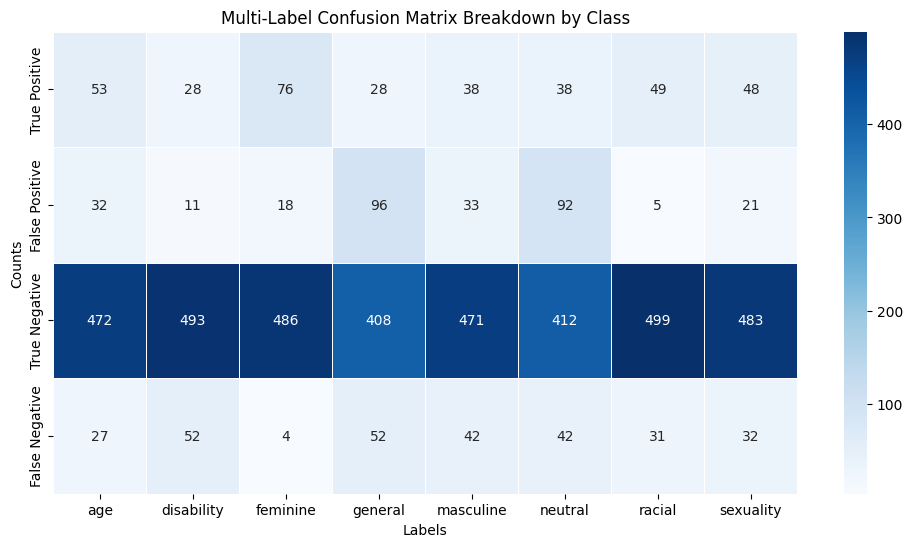

              precision    recall  f1-score   support

         age       0.62      0.66      0.64        80
  disability       0.72      0.35      0.47        80
    feminine       0.81      0.95      0.87        80
     general       0.23      0.35      0.27        80
   masculine       0.54      0.47      0.50        80
     neutral       0.29      0.47      0.36        80
      racial       0.91      0.61      0.73        80
   sexuality       0.70      0.60      0.64        80

   micro avg       0.54      0.56      0.55       640
   macro avg       0.60      0.56      0.56       640
weighted avg       0.60      0.56      0.56       640
 samples avg       0.55      0.59      0.56       640



In [12]:
from sklearn.metrics import classification_report

#num_tests=10
#data_to_test = processed_dataset[val_or_test_split].select(range(num_tests))
data_to_test = processed_dataset[val_or_test_split]

responses = pipeline(data_to_test['prompt'],
                    max_new_tokens=50,
                    return_full_text=False,
                    do_sample=False
                    )

#Extract labels
predictions, not_parsed = responses_to_predictions(responses)

print(f"Num not parsed: {len(not_parsed)}")

#There still may be a few unparseable responses. Remove these from the ground truth labels
#In testing, this has always been zero, therefore results are valid.
truth_labels = data_to_test['labels']
filtered_truth_labels = [label for idx, label in enumerate(truth_labels) if idx not in not_parsed]

metrics = compute_metrics(predictions, filtered_truth_labels)
print_metrics(metrics)

tp, fp, tn, fn = calculate_counts(np.array(filtered_truth_labels), np.array(predictions))
heatmap_TP_FP_TN_FN(tp, fp, tn, fn)

print(classification_report(filtered_truth_labels, predictions, target_names=labels, zero_division=0.0))

In [13]:
#responses